# Understanding Obesity (Prediction)

The objective of this project is to accurately classify individuals into different weight categories based on relevant features. We will explore the data and features, compute various machine learning algorithms with various parameters for optimisation, and evaluate their performance to identify the most effective model.

**Environment Setup**


In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

## Data Understanding

### Dataset Information

In [2]:
df = pd.read_csv('ObesityDataSet.csv')

nominal_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 
                   'SMOKE', 'SCC', 'MTRANS']
df[nominal_columns] = df[nominal_columns].astype('category')

ordinal_columns = ['CAEC', 'CALC', 'NObeyesdad']
category_order = {'CAEC': ['no', 'Sometimes', 'Frequently', 'Always'],
                  'CALC': ['no', 'Sometimes', 'Frequently', 'Always'],
                  'NObeyesdad': ['Insufficient_Weight', 'Normal_Weight', 
                                 'Overweight_Level_I', 'Overweight_Level_II', 
                                 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']}

for col in ordinal_columns:
    df[col] = pd.Categorical(df[col], categories=category_order[col], ordered=True)

    
display(df.head())
df.info()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Gender                          2111 non-null   category
 1   Age                             2111 non-null   float64 
 2   Height                          2111 non-null   float64 
 3   Weight                          2111 non-null   float64 
 4   family_history_with_overweight  2111 non-null   category
 5   FAVC                            2111 non-null   category
 6   FCVC                            2111 non-null   float64 
 7   NCP                             2111 non-null   float64 
 8   CAEC                            2111 non-null   category
 9   SMOKE                           2111 non-null   category
 10  CH2O                            2111 non-null   float64 
 11  SCC                             2111 non-null   category
 12  FAF                 

### Data Description

0. **Gender** - Gender
1. **Age** - Age
2. **Height** - Height
3. **Weight** - Weight
4. **family_history_with_overweight** - Family members suffered or suffers from overweight
5. **FAVC** - Frequent consumption of high caloric food
6. **FCVC** - Frequency of consumption of vegetables
7. **NCP** - Number of main meals
8. **CAEC** - Consumption of food between meals
9. **SMOKE** - Smoker or not
10. **CH20** - Consumption of water daily
11. **SCC** - Calories consumption monitoring
12. **FAF** - Physical activity frequency
13. **TUE** - Time using technology devices
14. **CALC** - Consumption of alcohol
15. **MTRANS** - Transportation used
16. **NObeyesdad** - Obesity level deducted


NObeyesdad values are computing using BMI values and categorised based on the following:
- Underweight - Less than 18.5
- Normal - 18.5 to 24.9
- Overweight - 25.0 to 29.9 (Unclear how Overweight I and II are divided)
- Obesity I - 30.0 to 34.9
- Obesity II - 35.0 to 39.9
- Obesity III - Higher than 40

### Missing Values

In [3]:
df.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

### Descriptive Statistics

In [4]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [5]:
df.describe(include='category')

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
count,2111,2111,2111,2111,2111,2111,2111,2111,2111
unique,2,2,2,4,2,2,4,5,7
top,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_I
freq,1068,1726,1866,1765,2067,2015,1401,1580,351


### Key Findings

- 2,111 rows.
- 16 features.
- 0 missing values.
- Target variable: 'NObeyesdad'.




* Average age is relatively young at 24 years old.
* Average height and weight are 1.70m and 86.6kg.
* Most individuals have family history of obesity and consume high caloric food.
* Public transport being the most common type of transportation.

## Exploratory Data Analysis

### Target Variable

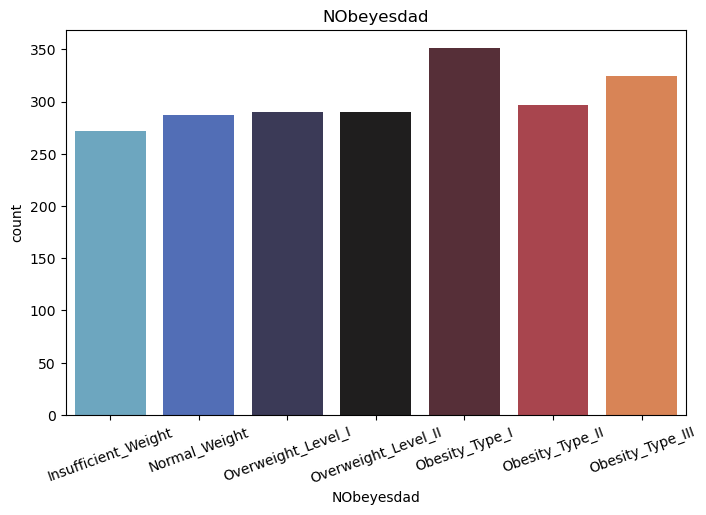

In [6]:
plt.figure(figsize=(8,5))
sns.countplot(x='NObeyesdad', data=df, hue='NObeyesdad', palette='icefire')
plt.title('NObeyesdad')
plt.xticks(rotation=20)
plt.show()

- The number of individuals increases with each higher weight classification.
- Obesity Type 1 and Insufficient Weight are the two most and least occuring weight categories.
- Distribution of the categories are notably proportionate, which suggests a good balanced representatiton of each weight category.

### Demographic features

**Gender**

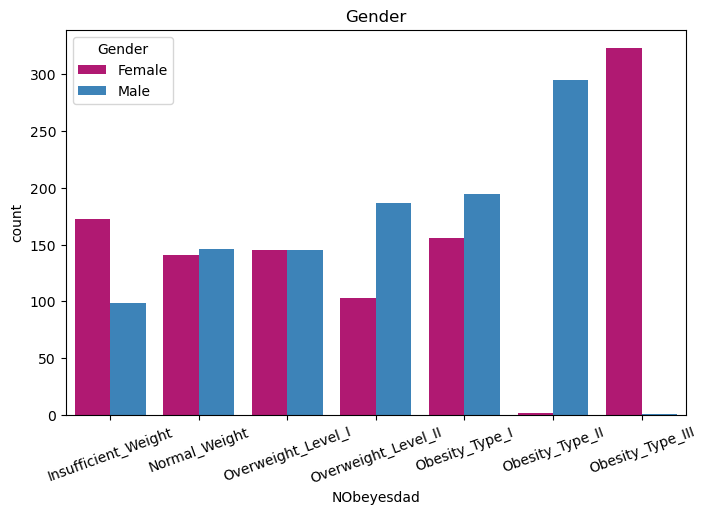

In [7]:
plt.figure(figsize=(8,5))
palette_gender = {'Male': '#2986cc', 'Female': '#c90076'}
sns.countplot(x='NObeyesdad', data=df, hue='Gender', palette=palette_gender)
plt.title('Gender')
plt.xticks(rotation=20)
plt.show()

- The weight category most frequently observed among females proves to be the least common category among males, and vice versa.
- Higher number of males fall into the Overweight categories compared to females. In contrast, more females are in the Insufficient weight and Obesity categories compared to males.
- Almost twice as many females fall into the heaviest weight class compared to any other female weight class.

**Age**

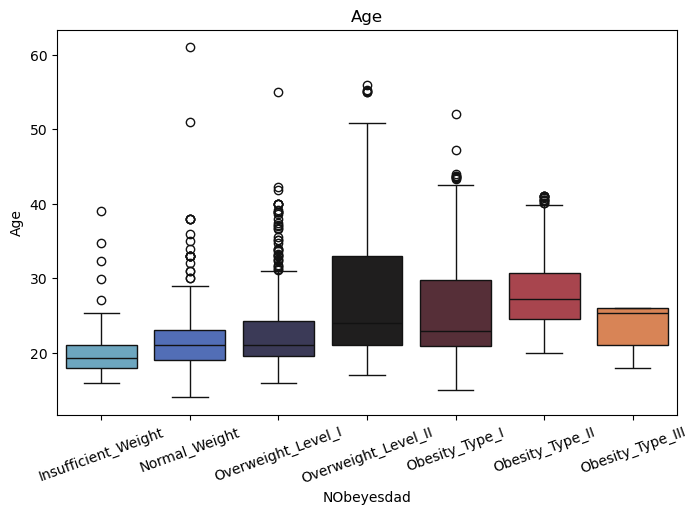

In [8]:
plt.figure(figsize=(8,5))
sns.boxplot(x='NObeyesdad', y='Age', data=df, hue='NObeyesdad', palette='icefire')
plt.title('Age')
plt.xticks(rotation=20)
plt.show()

- Individuals in heavier weight categories tend to be older, as they are more likely to fall into higher weight classifications as they age.
- Overweight Level II has the greatest variability, suggesting that this category may be diverse and not strictly tied to a specific age group, while Insufficient Weight tends occur within individuals who are less than 30 years old
- The Obesity Type III has a maximum age value of less than 30, while Normal Weight has an individual with age exceeding 60, suggesting that weight classes has a potential impact on life expectancy.

**Weight and Height**

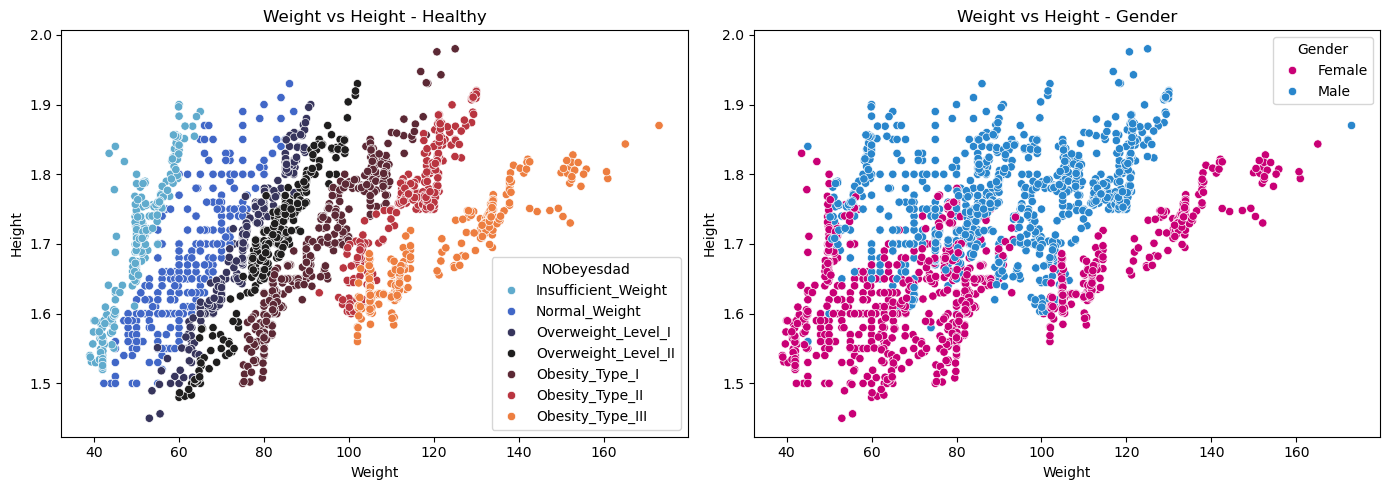

In [9]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Weight', y='Height', data=df, hue='NObeyesdad', palette='icefire')
plt.title('Weight vs Height - Healthy')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Weight', y='Height', data=df, hue='Gender', palette=palette_gender)
plt.title('Weight vs Height - Gender')

plt.tight_layout()
plt.show()

- Individuals with heavier weights, particularly when not proportionately compensated with taller heights, tend to fall into the heavier weight categories. This suggests that a disparity between weight and height may contribute to the classification of individuals into higher weight categories.
- Females are also seen with lower weights and shorter heights compared to males, as expected.

**Family history with overweight**

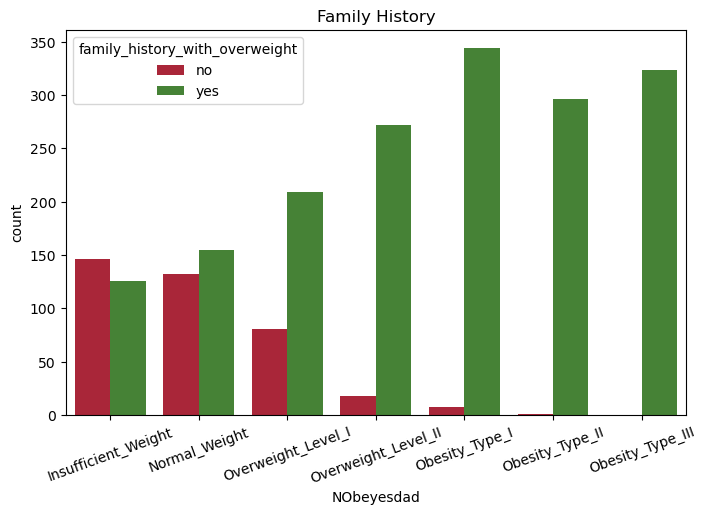

In [10]:
plt.figure(figsize=(8, 5))
palette_yesno = {'yes': '#3f8f29', 'no': '#bf1029'}
sns.countplot(x='NObeyesdad', data=df, hue='family_history_with_overweight', palette=palette_yesno)
plt.title('Family History')
plt.xticks(rotation=20)
plt.show()

- Individuals with no family history of being overweight are observed to have more individuals in the lighter weight classes. Likewise, more individuals are in the heavier categories when their family has a history of overweight.

### Eating Habit Features

**Consumption of high caloric food**

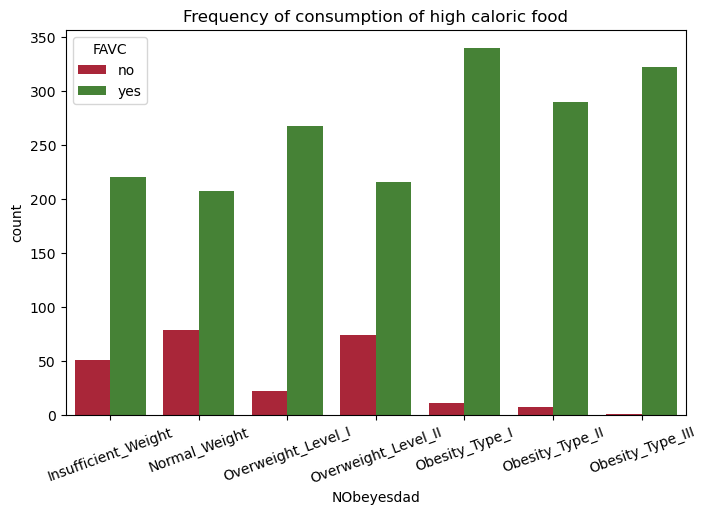

In [11]:
plt.figure(figsize=(8,5))
sns.countplot(x='NObeyesdad', data=df, hue='FAVC', palette=palette_yesno)
plt.title('Frequency of consumption of high caloric food')
plt.xticks(rotation=20)
plt.show()

- More individuals in heavier weight classes are seen to frequently consume high caloric food than those in lighter weight classes.
- Likewise, those in lighter weight classes do not frequently consume high caloric food.

**Consumption of vegetables**

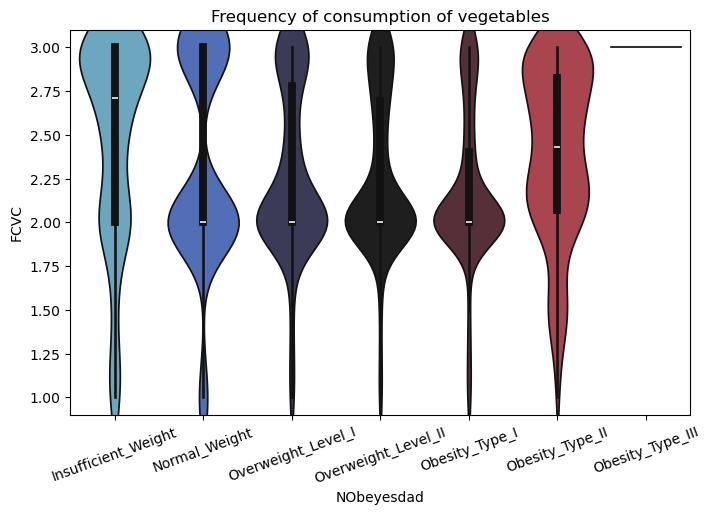

In [12]:
plt.figure(figsize=(8,5))
sns.violinplot(x='NObeyesdad', y='FCVC', data=df, hue='NObeyesdad', palette='icefire')
plt.title('Frequency of consumption of vegetables')
plt.xticks(rotation=20)
plt.ylim(df['FCVC'].min()-0.1, df['FCVC'].max()+0.1)
plt.show()

- Frequency of consuming vegetables decrease as with an increase of weight classes , specfically from a majority of individuals consuming more than 2.5 to a larger proportion opting for 2.0, except for Obesity Type II where almost an equal number of individuals from 2.0 to 3.0
- Obesity Type III has all indivdiduals with a frequency of 3.0

**Number of main meals**

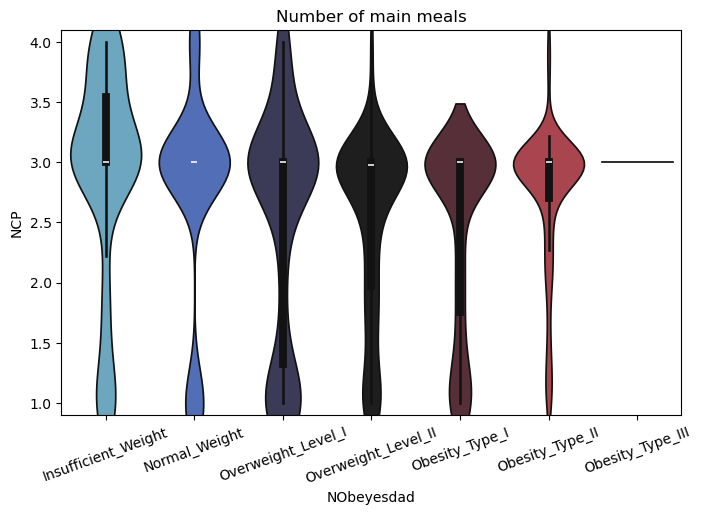

In [13]:
plt.figure(figsize=(8,5))
sns.violinplot(x='NObeyesdad', y='NCP', data=df, hue='NObeyesdad', palette='icefire')
plt.title('Number of main meals')
plt.xticks(rotation=20)
plt.ylim(df['NCP'].min()-0.1, df['NCP'].max()+0.1)
plt.show()

- All of the weight classes generally consume three meals. 
- However, ironically, the Insufficient Weight class has more individuals consuming more than 3 meals than other weight classes.

**Consumption of food between meals**

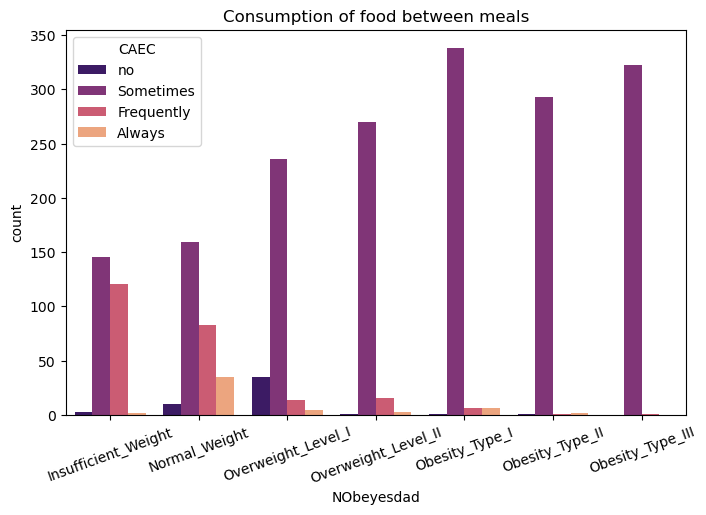

In [14]:
plt.figure(figsize=(8,5))
sns.countplot(x='NObeyesdad', data=df, hue='CAEC', palette='magma')
plt.title('Consumption of food between meals')
plt.xticks(rotation=20)
plt.show()

- Individuals generally consume food between their meals.
- Lighter weight classes are seen to consume more food inbetween their meals compared to heavier weight classes.

**Consumption of water daily**

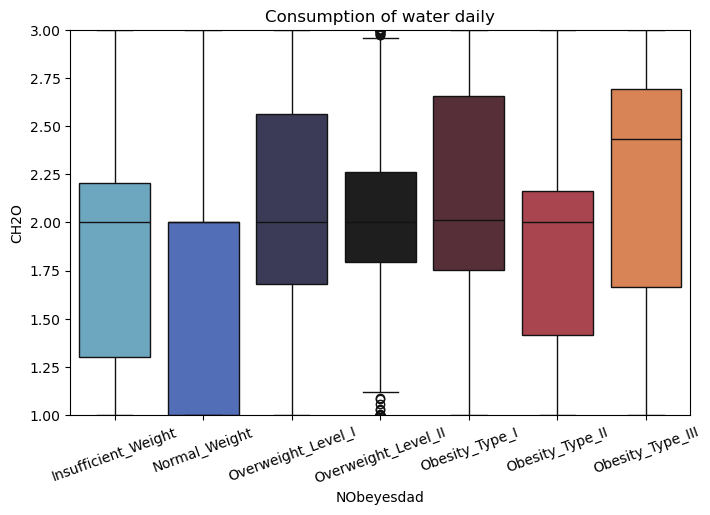

In [15]:
plt.figure(figsize=(8,5))
sns.boxplot(x='NObeyesdad', y='CH2O', data=df, hue='NObeyesdad', palette='icefire')
plt.title('Consumption of water daily')
plt.xticks(rotation=20)
plt.ylim(df['CH2O'].min(), df['CH2O'].max())
plt.show()

- Individuals generally consume the same amount of water.
- Water consumption increases as the weight classes get heavier.

**Consumption of alcohol**

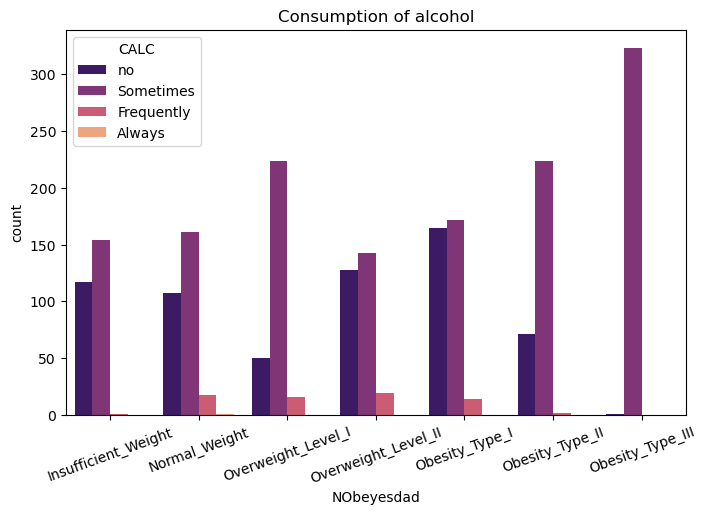

In [16]:
plt.figure(figsize=(8,5))
sns.countplot(x='NObeyesdad', data=df, hue='CALC', palette='magma')
plt.title('Consumption of alcohol')
plt.xticks(rotation=20)
plt.show()

- Alcohol consumption generally increases as the weight classes get heavier.
- Obesity Type III has almost no individuals not consuming alcohol, while the middle weight classes display a diverse range of alcohol consumption habits.

### Physical Habit Features 

**Smoking**

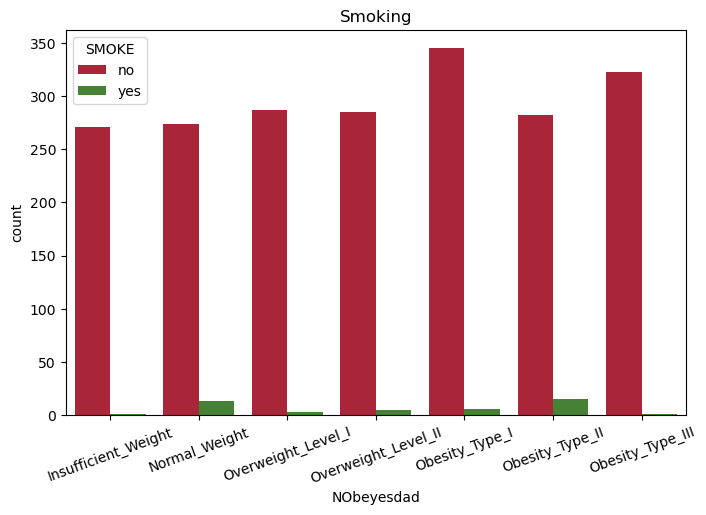

In [17]:
plt.figure(figsize=(8,5))
sns.countplot(x='NObeyesdad', data=df, hue='SMOKE', palette=palette_yesno)
plt.title('Smoking')
plt.xticks(rotation=20)
plt.show()

- Majority of individuals in each class do not smoke, while a small group in the middle weight classes smoke.

**Calories consumption monitoring**

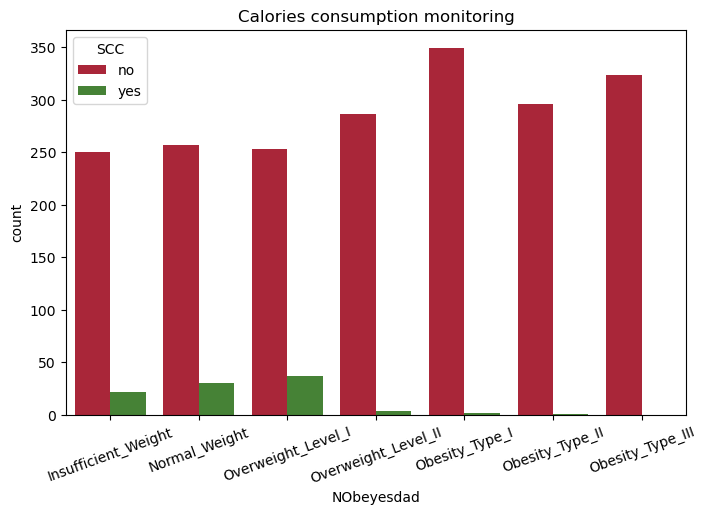

In [18]:
plt.figure(figsize=(8,5))
sns.countplot(x='NObeyesdad', data=df, hue='SCC', palette=palette_yesno)
plt.title('Calories consumption monitoring')
plt.xticks(rotation=20)
plt.show()

- Individuals across the weight categories are seen to not monitor their calories intake.
- It is only seen in the lighter weight categories that a small group of individuals monitor their intake.

**Physical activity frequency**

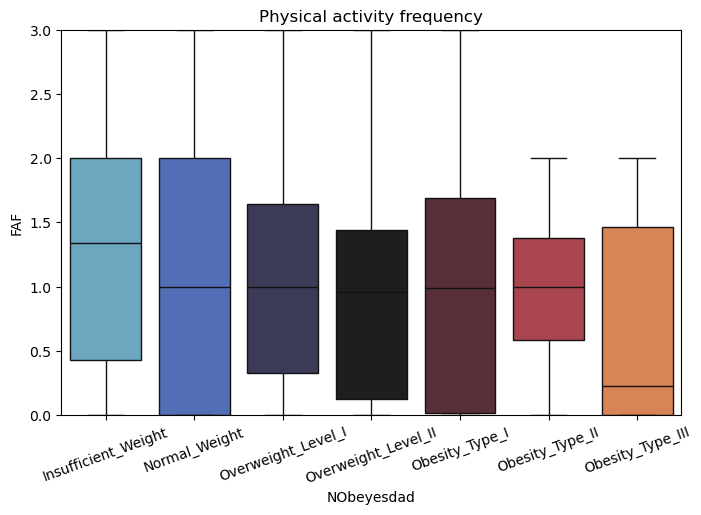

In [19]:
plt.figure(figsize=(8,5))
sns.boxplot(x='NObeyesdad', y='FAF', data=df, hue='NObeyesdad', palette='icefire')
plt.title('Physical activity frequency')
plt.xticks(rotation=20)
plt.ylim(df['FAF'].min(), df['FAF'].max())
plt.show()

- The frequency of physical activity decreases slightly as the weight classes get heavier.
- Only Obesity Type II and III have no individuals with a frequency of 2.0 and above, suggesting that these two classes generally have lower physical activity frequency compared to the other weight classes.

**Time using technology devices**

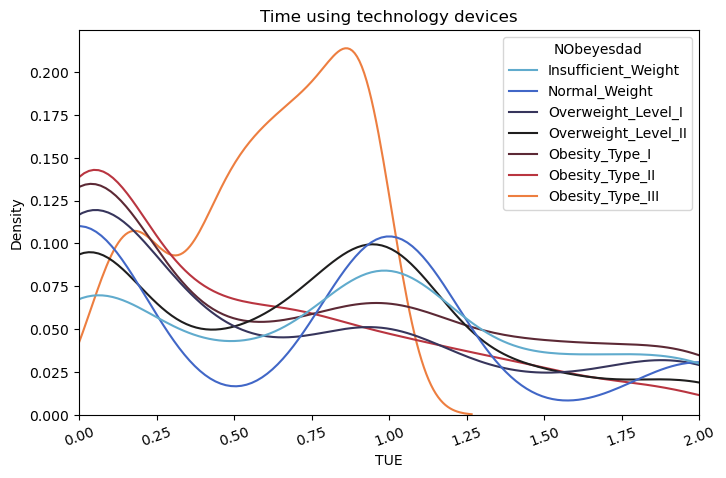

In [20]:
plt.figure(figsize=(8,5))
sns.kdeplot(x='TUE', data=df, hue='NObeyesdad', palette='icefire')
plt.title('Time using technology devices')
plt.xticks(rotation=20)
plt.xlim(df['TUE'].min(), df['TUE'].max())
plt.show()

- Individuals tend to have a greater number of people who spend less time on devices.
- Obesity Type III is also seen to have a greater number of individuals spending more time on devices.

**Transportation used**

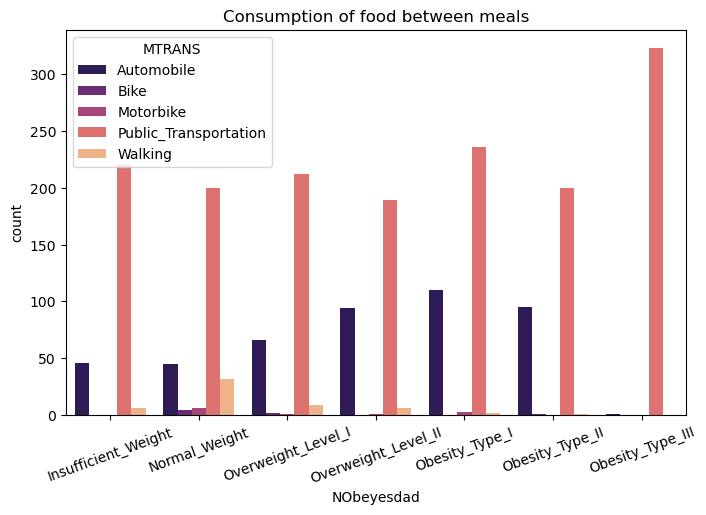

In [21]:
plt.figure(figsize=(8,5))
sns.countplot(x='NObeyesdad', data=df, hue='MTRANS', palette='magma')
plt.title('Consumption of food between meals')
plt.xticks(rotation=20)
plt.show()

- Public Transport is the most common mode of transportation, followed by automobile.
- Middle weight classes have more individuals using the automobile, while also having lesser individuals using the public transport.
- Normal Weight is also seen to have the most diversity of transportation used.

### Correlation Analysis

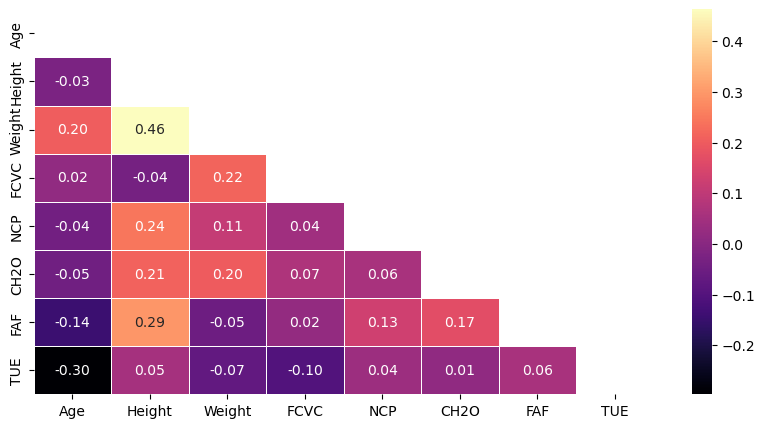

In [22]:
continuous_columns = df.select_dtypes(include='float64')
corr = continuous_columns.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", linewidths=.5, cmap='magma')
plt.show()

- As age increases, time spend on devices tend to decrease slightly.
- As height increases, weight tends to increase moderately.
- Taller individuals tend to slightly have more meals, drink more water daily and have more frequent physical activities.
- As weight increases, consumption of vegetables and daily water consumption increases slightly.

### Key Findings

Individuals in the heavier weight classes tend to:
- be older.
- be shorter or heavier than usual
- have a family history of overweight
- consume high caloric food
- have a higher frequency of vegetable consumption
- consume lesser or do not consume food between meals
- have slightly higher daily water consumption
- sometimes consume alcohol
- not monitor their calories consumption
- have lower frequency of physical activity
- spend more time on technology devices
- take the public transport and have a low diversity when selecting a transportation to use

## Data Preparation

**Feature Selection**

We will exclude the Height and Weight features, as the target variable computed using Height and Weight and categorised into the different weight classes.

In [23]:
df = df.drop(['Height', 'Weight'], axis=1)

**Outlier Detection and Removal**

We will remove outliers as they are data points that deviate significantly from the majority of the dataset and can introduce noise and distort the learning process of machine learning model. We will iterate through each feature and identify if its quantitative, calculate its IQR, lower and upper bounds and and retain values falling within these bounds.

For this case, the multiplier choice would be 3, hence any value below Q1 - 3 * IQR or above Q3 + 3 * IQR is considered an outlier.

In [24]:
for column in df:
    if df[column].dtype == 'float64':
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 3 * IQR
        upper = Q3 + 3 * IQR
        df = df[
            (df[column] >= lower) & (df[column] <= upper)]
        
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1762 entries, 0 to 2110
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Gender                          1762 non-null   category
 1   Age                             1762 non-null   float64 
 2   family_history_with_overweight  1762 non-null   category
 3   FAVC                            1762 non-null   category
 4   FCVC                            1762 non-null   float64 
 5   NCP                             1762 non-null   float64 
 6   CAEC                            1762 non-null   category
 7   SMOKE                           1762 non-null   category
 8   CH2O                            1762 non-null   float64 
 9   SCC                             1762 non-null   category
 10  FAF                             1762 non-null   float64 
 11  TUE                             1762 non-null   float64 
 12  CALC                     

**Feature Engineering**

To enhance model performance, we will convert categorical features that represent qualitative data into a numerical format for models to interpret them effectively. 

We will achieve this by one-hot encoding nominal features and label encoding ordinal features.

In [25]:
df = pd.get_dummies(df, columns=nominal_columns, drop_first=True)

label_encoder = LabelEncoder()
for column in ordinal_columns:
    df[column] = label_encoder.fit_transform(df[column])

**Data Normalisation**

Data normalisation standardises the scale of features, making them comparable and preventing features with larger values from dominating features with smaller values. We will also implement feature-wise normalisation, where the characteristic of the feature dictates the type of normalisation technique used.

Min-Max scaling will be used for features with specific range of values, while Z-score for features with distributions that are approximately normal.

In [26]:
scaler = StandardScaler()

minmax_columns = ['FCVC', 'NCP', 'CH2O']
zscore_columns = ['Age']

minmax_scaler = MinMaxScaler()
df[minmax_columns] = minmax_scaler.fit_transform(df[minmax_columns])

zscore_scaler = StandardScaler()
df[zscore_columns] = zscore_scaler.fit_transform(df[zscore_columns])

df.head()

,Age,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,-0.541299,0.5,0.572509,2,0.5,0.0,1.0,2,1,False,True,False,False,False,False,False,True,False
1,-0.541299,1.0,0.572509,2,1.0,3.0,0.0,1,1,False,True,False,True,True,False,False,True,False
2,-0.198114,0.5,0.572509,2,0.5,2.0,1.0,0,1,True,True,False,False,False,False,False,True,False
3,0.488255,1.0,0.572509,2,0.5,2.0,0.0,0,5,True,False,False,False,False,False,False,False,True
5,0.831440,0.5,0.572509,2,0.5,0.0,0.0,1,1,True,False,True,False,False,False,False,False,False


### Summary of Data Preparation

- Identified and removed outliers from quantitative features.
- One-hot encoded categorical features.
- Normalised quantitative features.

## Modeling

**Train-test Split**

We will divide the dataframe into training and testing sets. Our testing set will include 30% of the dataset that is stratified on our target variable to maintain the distribution of the target variable in both training and testing sets.

In [27]:
X = df.drop(['NObeyesdad'], axis=1)
y = df['NObeyesdad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

**Model Training and Evaluation Function**

We will create a function to simplify the process of training and evaluating an algorithm by automating hyperparameter tuning. The function performs a grid search to optimise model performance and updates the best performance into a dataframe. The function also reports the elapsed time for the entire search and outputs the best parameters found during the search.

In [28]:
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
f1_scorer = make_scorer(f1_score, average='weighted')
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def train_and_evaluate(name, model, model_params):
    print('Algorithm:',name)
    start_time = time.time()
    
    
    grid_search = GridSearchCV(model, model_params, scoring=f1_scorer, 
                               cv=skfold.split(X_train, y_train), verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f'Elapsed time: {elapsed_time:.2f}s')
    print('Best parameters:', grid_search.best_params_)
    print('')
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    precision = round(precision_score(y_test, y_pred, average='weighted') * 100, 2)
    recall = round(recall_score(y_test, y_pred, average='weighted') * 100, 2)
    f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
    
    metrics_df.loc[len(metrics_df)] = [name, accuracy, precision, recall, f1]

**Hyperparameter Tuning and Model Evaluation**

We will define the hyperparameter configuration for various classification algorithms. These configurations, consisting of algorithms and their respective parameters, will be used as input for the previously defined function. The parameter choices aim to find a balance between efficient run time and the number of fits during the model tuning process.

In [29]:
lgr_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 0.5, 1, 2],
    'max_iter': [3000, 4000, 5000, 6000],
    'solver': ['saga' ],
    'multi_class': ['ovr', 'multinomial'],
    'class_weight': [None, 'balanced'],
    'warm_start': [True, False],
    'random_state': [42]
}

svm_params = {
    'C': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [1, 2, 3, 4, 5],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'coef0': [0, 1, 2, 3],
    'random_state': [42]
}

dst_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 3, 4, 5, 8, 10, 15, 20],
    'min_samples_split': [2, 3, 4, 5, 8, 10, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5, 8, 10, 20],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3],
    'random_state': [42]
}

rfr_params = {
    'n_estimators': [300, 400, 500, 600],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 2, 3, 5, 7],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced'],
    'random_state': [42]
}

gbo_params = {
    'learning_rate': [0.05, 0.1, 0.5],
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 2, 3, 5, 7, 9],
    'random_state': [42]
}

xgb_params = {
    'learning_rate': [0.05, 0.1, 0.5],
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [None, 2, 3, 5, 7, 9],
    'random_state': [42]
}

models = {
    'Logistic Regression': (LogisticRegression(), lgr_params),
    'Support Vector Machine': (SVC(), svm_params),
    'Decision Tree': (DecisionTreeClassifier(), dst_params),
    'Random Forest': (RandomForestClassifier(), rfr_params),
    'Gradient Boosting': (GradientBoostingClassifier(), gbo_params),
    'Extreme Gradient Boosting': (XGBClassifier(), xgb_params)
}

for name, (model, params) in models.items():
    train_and_evaluate(name, model, params)

Algorithm: Logistic Regression
Fitting 10 folds for each of 256 candidates, totalling 2560 fits
Elapsed time: 48.94s
Best parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 3000, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 42, 'solver': 'saga', 'warm_start': True}

Algorithm: Support Vector Machine
Fitting 10 folds for each of 2880 candidates, totalling 28800 fits
Elapsed time: 108.78s
Best parameters: {'C': 8, 'coef0': 0, 'degree': 5, 'gamma': 0.1, 'kernel': 'poly', 'random_state': 42}

Algorithm: Decision Tree
Fitting 10 folds for each of 12096 candidates, totalling 120960 fits
Elapsed time: 39.21s
Best parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'random'}

Algorithm: Random Forest
Fitting 10 folds for each of 240 candidates, totalling 2400 fits
Elapsed time: 113.54s
Best parameters: {'bootstrap': False, 'class_weight': None, 'criterion':

# Results and Conclusion

### Model Evaluation

**Model Performance**

In [30]:
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,58.03,56.24,58.03,56.40
1,Support Vector Machine,78.45,78.07,78.45,78.06
2,Decision Tree,73.16,72.99,73.16,73.03
3,Random Forest,86.20,86.79,86.20,86.21
4,Gradient Boosting,84.88,85.61,84.88,84.92
5,Extreme Gradient Boosting,83.74,84.16,83.74,83.76


We can see that most models performed resonably well except for Logistic Regression. Overall, the ensemble methods, such as Random Forest and Gradient Boosting, performed better than individual models like Logistic Regression and Decision Tree.

Since Random Forest performed was the best performer across all metrics, we will create a new model using it along with the identified optimal parameters. This helps us better understand its classification capabilities.

In [31]:
rfr_best_params = {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 500, 'random_state': 42}
rfr_model = RandomForestClassifier(**rfr_best_params)
rfr_model.fit(X_train, y_train)
y_pred = rfr_model.predict(X_test)

**Feature Importance**

Lets delve into the optimal model to gain insights into the key features it relies on for effective prediction of the target variable. This analysis will help us identify the most important features, providing valuable information about the factors contributing significantly to the model's predictive capabilities.

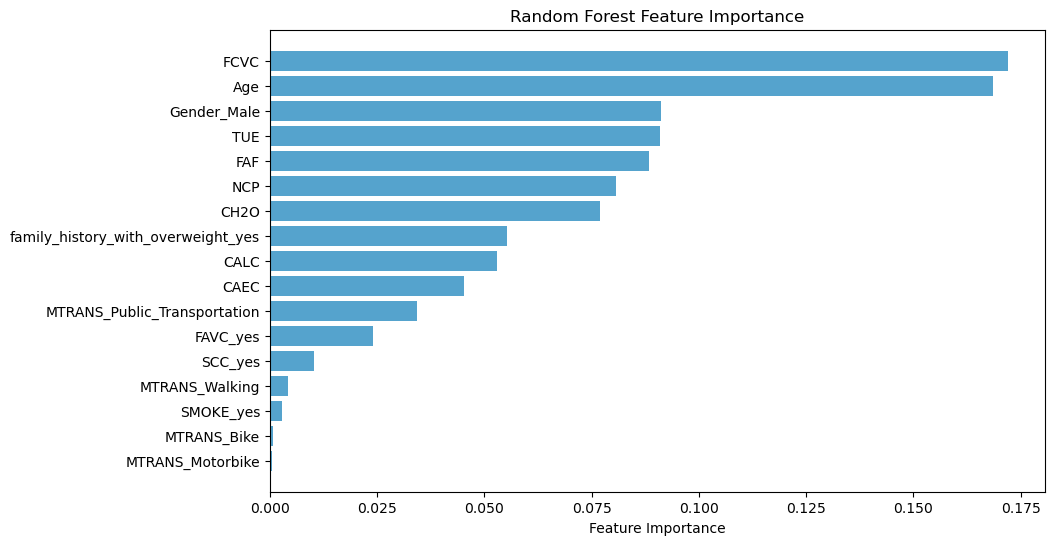

In [32]:
feature_names = X.columns
feature_importances = rfr_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

sns.set_palette('icefire')
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

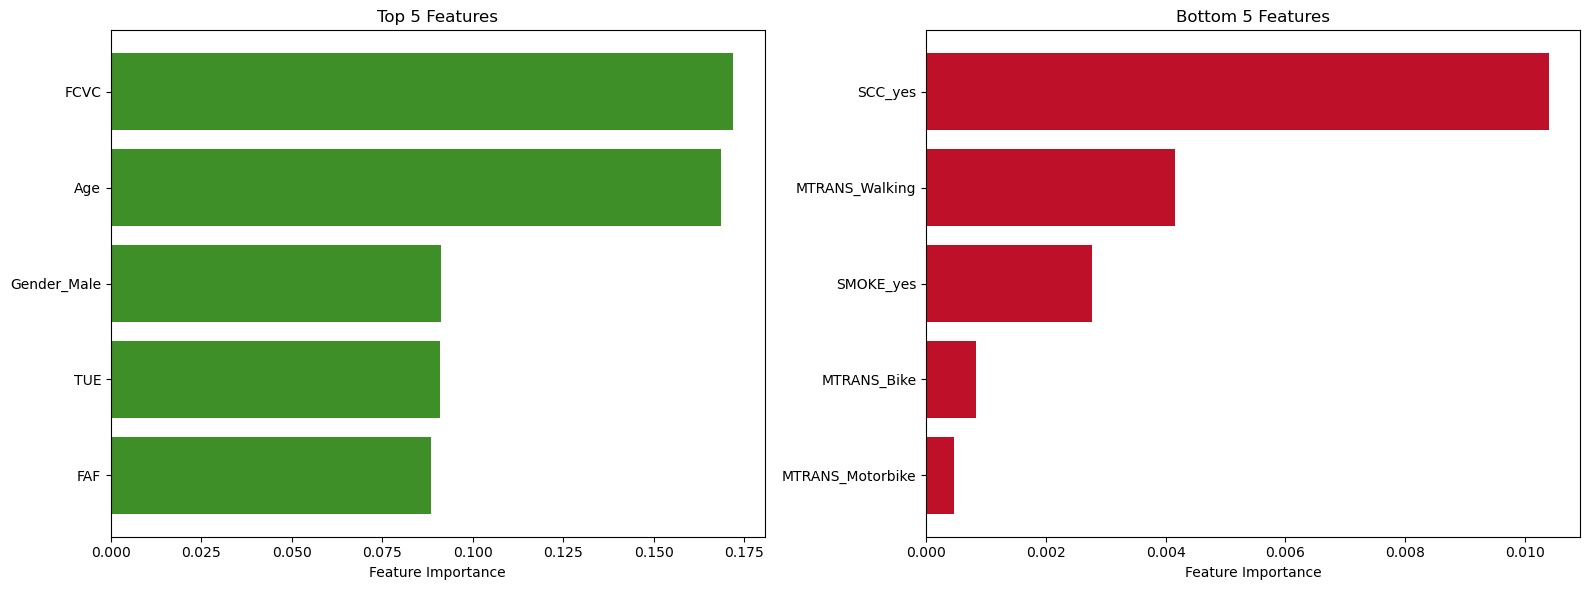

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top5 = len(feature_importance_df) - 5
axes[0].barh(feature_importance_df['Feature'][top5:], feature_importance_df['Importance'][top5:], color='#3f8f29')
axes[0].set_xlabel('Feature Importance')
axes[0].set_title('Top 5 Features')

btm5 = 5
axes[1].barh(feature_importance_df['Feature'][:btm5], feature_importance_df['Importance'][:btm5], color='#bf1029')
axes[1].set_xlabel('Feature Importance')
axes[1].set_title('Bottom 5 Features')

plt.tight_layout()
plt.show()

We can see that vegetable consumption frequency, age, gender, time using technology devices and physical activity frequency has the biggest impact in accurate classification.

In contrast, monitoring calories consumption, type of transport used and smoking has the least impact in accurate classification.

**Confusion Matrix**

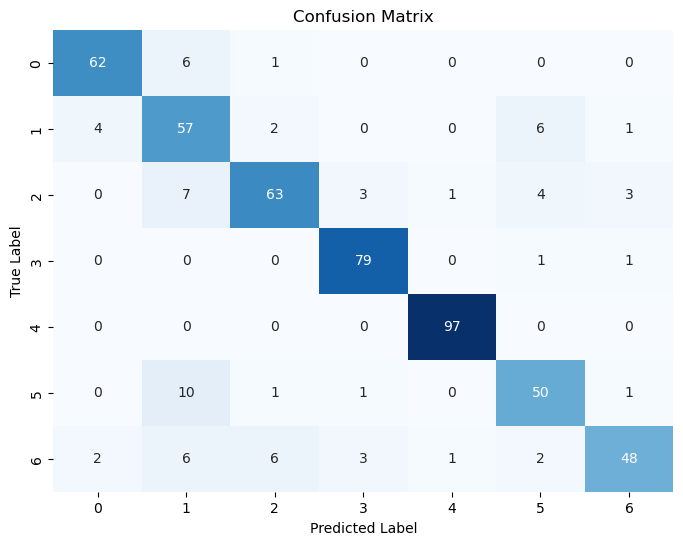

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=rfr_model.classes_, yticklabels=rfr_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Classification Report**

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91        69
           1       0.66      0.81      0.73        70
           2       0.86      0.78      0.82        81
           3       0.92      0.98      0.95        81
           4       0.98      1.00      0.99        97
           5       0.79      0.79      0.79        63
           6       0.89      0.71      0.79        68

    accuracy                           0.86       529
   macro avg       0.86      0.85      0.85       529
weighted avg       0.87      0.86      0.86       529



The model achieving an overall accuracy of 86% indicates a strong ability to correctly classify the target variable. The precision and recall values across the different weight classes are generally high, indicating the model's ability to identify specific classes.

It's worth highlightly that the model was able to accurately identifying all individuals with Obesity Type I (class 4). This may come from the fact that this class has the largest number of instances in the dataset. The model performs the worst at classifying Normal Weight (class 1) may suggest that the data used might not provide sufficient discriminative features for accurately classifying individuals with Normal Weight, unlike the other classes.

### Conclusion

In conclusion, the model evaluation reveals various performance among different algorithms, with ensemble methods like Random Forest and Gradient Boosting outperforming individual models such as Logistic Regression and Decison Tree. Random Forest together with its optimal parameters resulted in the best overall performance across accuracy, precision, recall, and F1 score metrics.

The feature importance analysis highlights key factors influencing the model's predictions, with vegetable consumption frequency, age, gender, time using technology devices, and physical activity frequency being the most impactful. Conversely, monitoring calorie consumption, type of transport used, and smoking have a relatively lower impact on accurate classification.

The model achieves an impressive accuracy of 86%, showcasing its ability to correctly classify individuals into weight categories. Notably, the model excels in identifying individuals with Obesity Type I, benefiting from the larger number of instances in this class. However, it faces challenges in accurately classifying individuals with Normal Weight, suggesting potential limitations in the available data for this particular category.

In summary, the model demonstrates strong predictive capabilities, especially in categories with ample data representation, while recognizing the need for further refinement, particularly for less represented classes.